In [1]:
#Importar librerias utilizadas y leyendo datos
import matplotlib as mp 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

#el formato de archivo es en excel
archivo_xlsx = 'datos_red1.xlsx' 

#leer el archivo .xlsx en un DataFrame
data = pd.read_excel(archivo_xlsx)
print(data.head()) #mostrar el inicio del DataFrame

        Date  Cloud coverage  Visibility  Temperature  Dew point  \
0 2016-02-01            0.10        9.45         3.11       0.32   
1 2016-02-02            0.80        3.94         6.99       6.22   
2 2016-02-03            0.87        8.70         1.62       0.02   
3 2016-02-04            0.37       10.00        -2.47      -5.89   
4 2016-02-05            0.52        9.21        -2.00      -4.15   

   Relative humidity  Wind speed  Station pressure  Altimeter  Solar energy  \
0              79.46        4.70             29.23      30.02         20256   
1              93.60       13.29             28.91      29.70          1761   
2              85.00       16.73             29.03      29.82          2775   
3              74.52        9.46             29.46      30.26         28695   
4              82.03        5.92             29.55      30.35          9517   

   (Inverters)  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


In [2]:
#seleccionar variables a utilizar en forma de vectores
fecha = data.iloc[:, 0]
solar_energy = data.iloc[:, 9]
cloud_coverage = data.iloc[:, 1]
#print(fecha)
#print(solar_energy)
print(cloud_coverage)

0      0.10
1      0.80
2      0.87
3      0.37
4      0.52
       ... 
632    0.23
633    0.01
634    0.89
635    0.99
636    0.58
Name: Cloud coverage, Length: 637, dtype: float64


Correlación de Pearson, con cobertura nubosa [1,0]: 0.69


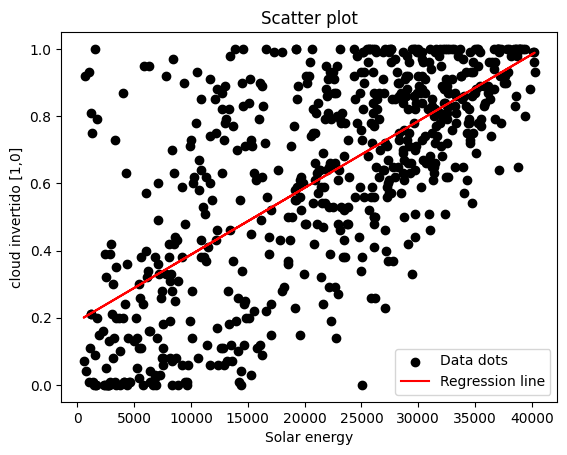

In [3]:
cloud_invertido = 1 - cloud_coverage 

correlation = data['Solar energy'].corr(cloud_invertido) 
print(f"Correlación de Pearson, con cobertura nubosa [1,0]: {correlation:.2f}")

plt.scatter(solar_energy, cloud_invertido, label="Data dots", color="black")
slope, intercept = np.polyfit(solar_energy, cloud_invertido, 1)
regression_line = slope * solar_energy + intercept
plt.plot(solar_energy, regression_line, color='r', label='Regression line')
# Etiquetas y título del gráfico
plt.xlabel("Solar energy")
plt.ylabel("cloud invertido [1,0]")
plt.title("Scatter plot")
plt.legend()
plt.show()

In [5]:
fechas = pd.to_datetime(fecha, format="%m/%d/%Y")

#dejamos todos los datos en un dataframe (o matriz)
df = pd.DataFrame({'Fecha': fechas, 'Valores': solar_energy, 'Cloud' : cloud_invertido})
semana1_df = df.iloc[608:,]


In [6]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Valores', 'Cloud']] = scaler.fit_transform(df[['Valores', 'Cloud']])
print(df)

         Fecha   Valores  Cloud
0   2016-02-01  0.496054   0.90
1   2016-02-02  0.029774   0.20
2   2016-02-03  0.055338   0.13
3   2016-02-04  0.708811   0.63
4   2016-02-05  0.225312   0.48
..         ...       ...    ...
632 2017-10-25  0.331703   0.77
633 2017-10-26  0.677802   0.99
634 2017-10-27  0.383638   0.11
635 2017-10-28  0.146729   0.01
636 2017-10-29  0.200605   0.42

[637 rows x 3 columns]


In [7]:
#Una vez normalizados, se necesita que sean datos supervisados 
data = df
#definir el tamaño del paso (look-back), por ejemplo, 20
#elegimos 20 para probar, pues en la correlacion con desfase habia un maximo con 19 valores desplazados.
look_back = 20
X, y = [], [] #para las secuencias temporales de entrada (X) y salida (y)

for i in range(len(data) - look_back):
    #crea una secuencia temporal de cloud
    seq_cloud = data['Cloud'][i:i+look_back].tolist()
    
    #obtiene el valor de energia solar en el siguiente paso de tiempo
    target = data['Valores'][i+look_back]
    
    # Agrega la secuencia temporal a X y el valor de salida a y
    X.append(seq_cloud)
    y.append(target)

# Convierte las listas X y y en DataFrames si es necesario
X = pd.DataFrame(X, columns=[f'Cloud(t-{i})' for i in range(look_back, 0, -1)])
y = pd.Series(y, name='Valores(t+1)')

# X contendrá las secuencias temporales de temperatura y y contendrá los valores de energía solar en el siguiente paso de tiempo
print(X)
print(y)

     Cloud(t-20)  Cloud(t-19)  Cloud(t-18)  Cloud(t-17)  Cloud(t-16)  \
0           0.90         0.20         0.13         0.63         0.48   
1           0.20         0.13         0.63         0.48         0.87   
2           0.13         0.63         0.48         0.87         0.79   
3           0.63         0.48         0.87         0.79         0.13   
4           0.48         0.87         0.79         0.13         0.00   
..           ...          ...          ...          ...          ...   
612         0.11         0.05         0.61         0.57         0.64   
613         0.05         0.61         0.57         0.64         0.06   
614         0.61         0.57         0.64         0.06         0.00   
615         0.57         0.64         0.06         0.00         0.26   
616         0.64         0.06         0.00         0.26         0.65   

     Cloud(t-15)  Cloud(t-14)  Cloud(t-13)  Cloud(t-12)  Cloud(t-11)  \
0           0.87         0.79         0.13         0.00        

In [11]:
from sklearn.model_selection import train_test_split
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Definir la arquitectura de la red neuronal

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8449 (33.00 KB)
Trainable params: 8449 (33.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
9/9 - 2s - loss: 0.2601 - val_loss: 0.0799 - 2s/epoch - 198ms/step
Epoch 2/500
9/9 - 0s - loss: 0.1132 - val_loss: 0.0824 - 70ms/epoch - 8ms

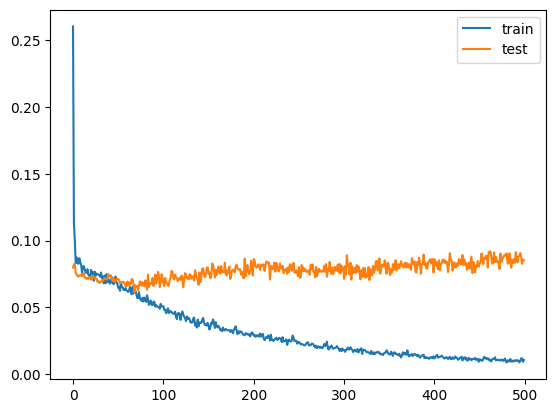

In [14]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot
from keras.layers import Dense, Dropout

model = Sequential() 
# Agregar una capa RNN con 64 nodos
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], 1)))
#model.add(LSTM(64, input_shape=(X_train.shape[1],1)))
model.add(Dense(64, activation='relu')) #capa oculta  #relu para que salga con valores de 0 a 1
model.add(Dropout(0.4))
# Agregar una capa densa para la salida
model.add(Dense(1)) 

# Compilar el modelo con una función de pérdida y un optimizador
model.compile(loss='mean_squared_error', optimizer='adam') #: Calcula el error cuadratico medio.

# Imprimir un resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio entre el valor de salida y el esperado
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio en el conjunto de prueba: {mse:.2f}")
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

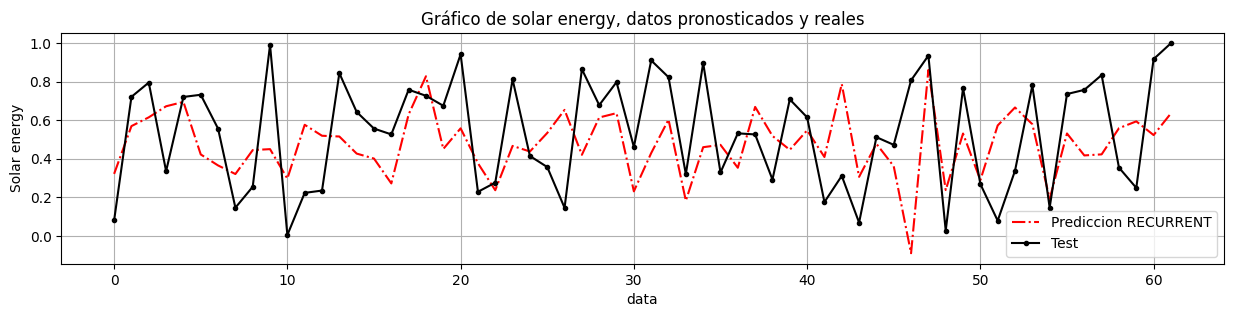

In [15]:
#grafico de linea 
serie= y_test
serie_reset = serie.reset_index(drop=True)
plt.figure(figsize=(15, 3))  # Tamaño del gráfico
plt.plot(y_pred, linestyle='-.', color='r',label='Prediccion RECURRENT')
plt.plot(serie_reset, marker='.', linestyle='-', color='k', label='Test')
plt.title('Gráfico de solar energy, datos pronosticados y reales')
plt.xlabel('data')
plt.ylabel('Solar energy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/500
9/9 - 3s - loss: 0.3567 - val_loss: 0.2403 - 3s/epoch - 278ms/step
Epoch 2/500
9/9 - 0s - loss: 0.2420 - val_loss: 0.2407 - 122ms/epoch - 14ms/step
Epoch 3/500
9/9 - 0s - loss: 0.2271 - val_loss: 0.2397 - 134ms/epoch - 15ms/step
Epoch 4/500
9/9 - 0s - loss: 0.2204 - val_loss: 0.2363 - 140ms/epoch - 16ms/step
Epoch 5/500
9/9 - 0s - loss: 0.2247 - val_loss: 0.2376 - 122ms/epoch - 14ms/step
Epoch 6/500
9/9 - 0s - loss: 0.2221 - val_loss: 0.2362 - 126ms/epoch - 14ms/step
Epoch 7/500
9/9 - 0s - loss: 0.2245 - val_loss: 0.2356 - 129ms/epoch - 14ms/step
Epoch 8/500
9/9 - 0s - loss: 0.2193 - val_loss: 0.2355 - 121ms/epoch - 13ms/step
Epoch 9/500
9/9 - 0s - loss: 0.2219 - val_loss: 0.2351 - 120ms/epoch - 13ms/step
Epoch 10/500
9/9 - 0s - loss: 0.2170 - val_loss: 0.2350 - 120ms/epoch - 13ms/step
Epoch 11/500
9/9 - 0s - loss: 0.2228 - val_loss: 0.2337 - 127ms/epoch - 14ms/step
Epoch 12/500
9/9 - 0s - loss: 0.2213 - val_loss: 0.2343 - 121ms/epoch - 13ms/step
Epoch 13/500
9/9 - 0s - los

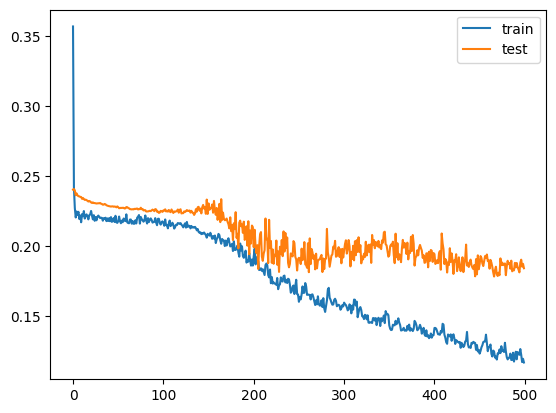

In [75]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1],1)))
model.add(Dense(64, activation='relu')) #capa oculta  #relu para que salga con valores de 0 a 1
model.add(Dropout(0.07))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
y_pred6= model.predict(X_test)
mse = mean_squared_error(y_test, y_pred6)
print(f"Error Cuadrático Medio en el conjunto de prueba: {mse:.2f}")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

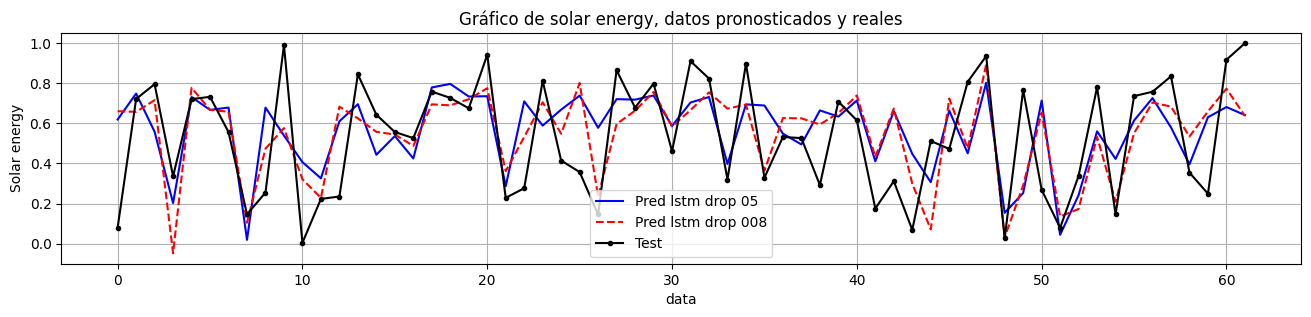

In [87]:
plt.figure(figsize=(16, 3))  # Tamaño del gráfico
#plt.plot(y_pred2, linestyle='-', color='b',label='Pred lstm drop 09')
plt.plot(y_pred3, linestyle='-', color='b',label='Pred lstm drop 05')
#plt.plot(y_pred5, linestyle='-', color='orange',label='Pred lstm drop 001')
plt.plot(y_pred6, linestyle='--', color='r',label='Pred lstm drop 008')
plt.plot(serie_reset, marker='.', linestyle='-', color='k', label='Test')
plt.title('Gráfico de solar energy, datos pronosticados y reales')
plt.xlabel('data')
plt.ylabel('Solar energy')
plt.legend()
plt.grid(True)
plt.show()

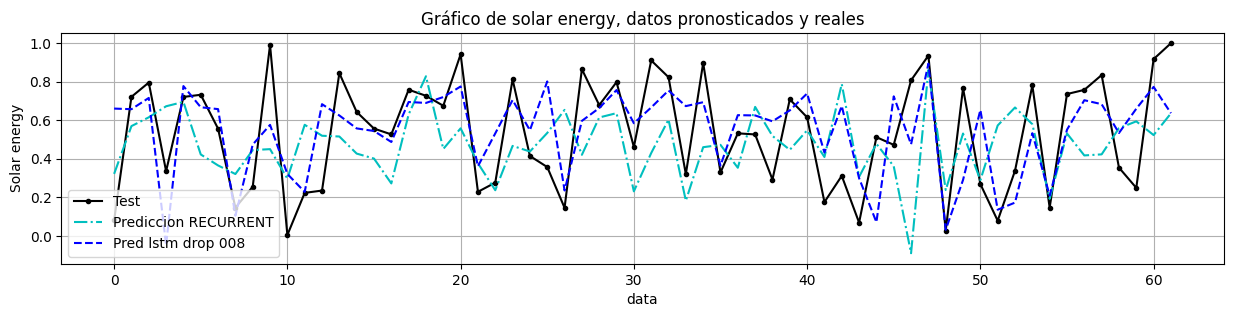

In [89]:
#grafico de linea 
serie= y_test
serie_reset = serie.reset_index(drop=True)
plt.figure(figsize=(15, 3))  # Tamaño del gráfico
plt.plot(serie_reset, marker='.', linestyle='-', color='k', label='Test')
plt.plot(y_pred, linestyle='-.', color='c',label='Prediccion RECURRENT')
plt.plot(y_pred6, linestyle='--', color='b',label='Pred lstm drop 008')
plt.title('Gráfico de solar energy, datos pronosticados y reales')
plt.xlabel('data')
plt.ylabel('Solar energy')
plt.legend()
plt.grid(True)
plt.show()